<a href="https://colab.research.google.com/github/MoeinDSP/Bittensor_Reddit_Dataset_NLP_Pipeline/blob/main/Models/1_Training_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

path = '/content/drive/MyDrive/Reddit_dataset'

os.chdir(f'{path}')
os.getcwd()

'/content/drive/MyDrive/Reddit_dataset'

Epoch 1: Train Acc = 0.3757, Test Acc = 0.4449
Epoch 2: Train Acc = 0.5052, Test Acc = 0.5132
Epoch 3: Train Acc = 0.5708, Test Acc = 0.5618
Epoch 4: Train Acc = 0.6122, Test Acc = 0.5805
Epoch 5: Train Acc = 0.6392, Test Acc = 0.5849
Epoch 6: Train Acc = 0.6623, Test Acc = 0.5997
Epoch 7: Train Acc = 0.6799, Test Acc = 0.5984
Epoch 8: Train Acc = 0.6945, Test Acc = 0.5987
Epoch 9: Train Acc = 0.7079, Test Acc = 0.5957
Epoch 10: Train Acc = 0.7187, Test Acc = 0.5974
Epoch 11: Train Acc = 0.7271, Test Acc = 0.5979
Epoch 12: Train Acc = 0.7347, Test Acc = 0.5959
Epoch 13: Train Acc = 0.7432, Test Acc = 0.5961
Epoch 14: Train Acc = 0.7498, Test Acc = 0.5902
Epoch 15: Train Acc = 0.7550, Test Acc = 0.5881
Epoch 16: Train Acc = 0.7615, Test Acc = 0.5856
Epoch 17: Train Acc = 0.7666, Test Acc = 0.5856
Epoch 18: Train Acc = 0.7709, Test Acc = 0.5811
Epoch 19: Train Acc = 0.7749, Test Acc = 0.5830
Epoch 20: Train Acc = 0.7784, Test Acc = 0.5796


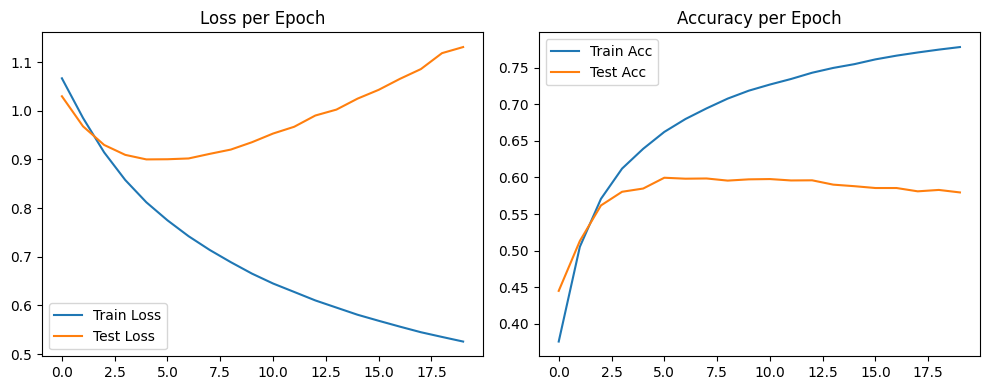

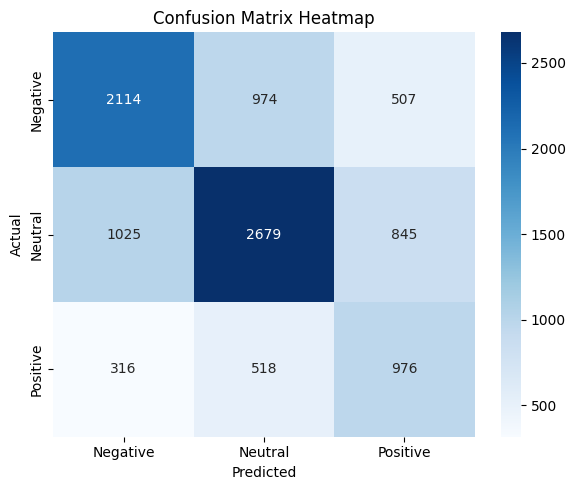

In [26]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import re
from collections import Counter
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("Finance_50K_Cleaned_Labels.csv")

# Encode labels
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["clean_label"])

# Tokenizer
def simple_tokenizer(text):
    return re.findall(r"\b\w+\b", text.lower())

# Build vocabulary
all_tokens = [token for text in df["preprocessed_text"] for token in simple_tokenizer(text)]
vocab_counter = Counter(all_tokens)
vocab = {"<PAD>": 0, "<UNK>": 1}
for token, count in vocab_counter.items():
    if count >= 3:
        vocab[token] = len(vocab)

def encode(text, vocab, max_len=50):
    tokens = simple_tokenizer(text)
    ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens[:max_len]]
    ids += [vocab["<PAD>"]] * (max_len - len(ids))
    return ids

# Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.data = [encode(text, vocab) for text in texts]
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx]), torch.tensor(self.labels[idx])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df["preprocessed_text"], df["label_encoded"], test_size=0.2, stratify=df["label_encoded"], random_state=42
)

train_dataset = SentimentDataset(X_train.tolist(), y_train.tolist(), vocab)
test_dataset = SentimentDataset(X_test.tolist(), y_test.tolist(), vocab)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Linear Classifier
class LinearSentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        pooled = embedded.mean(dim=1)
        return self.fc(pooled)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LinearSentimentClassifier(len(vocab), 100, 3).to(device)

# Training setup
# criterion = nn.CrossEntropyLoss()
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use in loss function
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

for epoch in range(20):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Eval
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    test_losses.append(total_loss / len(test_loader))
    test_accuracies.append(correct / total)
    print(f"Epoch {epoch+1}: Train Acc = {train_accuracies[-1]:.4f}, Test Acc = {test_accuracies[-1]:.4f}")

# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.title("Loss per Epoch")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(test_accuracies, label="Test Acc")
plt.legend()
plt.title("Accuracy per Epoch")
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Collect predictions
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)
labels = le.classes_  # ['Negative', 'Neutral', 'Positive']

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.tight_layout()
plt.show()
